C:\working_space\airfoil_project\airfoil에서 29개의 이미지를 로드했습니다.
이미지 데이터의 형태: (29, 64, 64, 3)
첫 번째 이미지의 최대 값: 1.0, 최소 값: -1.0


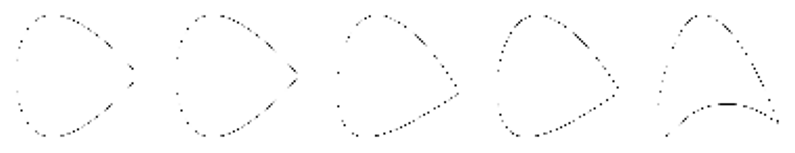

이미지 데이터의 평균: 0.9800102114677429, 표준편차: 0.1815299689769745
이미지 데이터의 최대 값: 1.0, 최소 값: -1.0


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 이미지 로드 및 전처리 함수
def load_images(folder, image_size=(64, 64)):
    images = []
    for img_path in glob(os.path.join(folder, '*.png')):
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # [-1, 1]로 정규화
        images.append(img)
    return np.array(images)

# 데이터 폴더 및 이미지 크기 설정
image_folder = "C:\\working_space\\airfoil_project\\airfoil"
image_size = (64, 64)

# 이미지 로드
images = load_images(image_folder, image_size)
print(f"{image_folder}에서 {len(images)}개의 이미지를 로드했습니다.")

# 데이터의 구성 확인
print(f"이미지 데이터의 형태: {images.shape}")
print(f"첫 번째 이미지의 최대 값: {np.max(images[0])}, 최소 값: {np.min(images[0])}")

# 샘플 이미지 시각화
def plot_sample_images(images, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] * 0.5 + 0.5))  # [0, 1]로 재조정
        plt.axis("off")
    plt.show()

# 샘플 이미지 시각화
plot_sample_images(images)

# 데이터 통계
print(f"이미지 데이터의 평균: {np.mean(images)}, 표준편차: {np.std(images)}")
print(f"이미지 데이터의 최대 값: {np.max(images)}, 최소 값: {np.min(images)}")


In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D, Conv2D, ZeroPadding2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


image_folder = "C:\\working_space\\airfoil_project\\airfoil"

# 이미지 로드 함수
def load_images(image_folder, image_size):
    images = []
    for filename in os.listdir(image_folder):
        img = load_img(os.path.join(image_folder, filename), target_size=image_size)
        if img is not None:
            images.append(img_to_array(img))
    return np.array(images)

# DCGAN 클래스 정의
class DCGAN:
    def __init__(self, img_rows, img_cols, channels, latent_dim):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()

        z = tf.keras.layers.Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = tf.keras.layers.Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        X_train = load_images(image_folder, (self.img_rows, self.img_cols))
        X_train = X_train / 127.5 - 1.0

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(f"images/dcgan_{epoch}.png")
        plt.close()

# 사용 예시
dcgan = DCGAN(img_rows=64, img_cols=64, channels=3, latent_dim=100)
dcgan.train(epochs=10000, batch_size=32, save_interval=100)


1/1 [==============================] - 0s 258ms/step
0 [D loss: 1.268731415271759, acc.: 21.875] [G loss: 0.7364834547042847]
1/1 [==============================] - 0s 165ms/step
1 [D loss: 0.8567885756492615, acc.: 56.25] [G loss: 0.8640117645263672]
1/1 [==============================] - 0s 130ms/step
2 [D loss: 0.41711558401584625, acc.: 81.25] [G loss: 1.1331452131271362]
1/1 [==============================] - 0s 110ms/step
3 [D loss: 0.43237361311912537, acc.: 82.8125] [G loss: 1.4301443099975586]
1/1 [==============================] - 0s 136ms/step
4 [D loss: 0.4857262969017029, acc.: 78.125] [G loss: 1.688774585723877]
1/1 [==============================] - 0s 112ms/step
5 [D loss: 0.39198657870292664, acc.: 82.8125] [G loss: 1.9697563648223877]
1/1 [==============================] - 0s 161ms/step
6 [D loss: 0.37651170790195465, acc.: 89.0625] [G loss: 2.280282974243164]
1/1 [==============================] - 0s 140ms/step
7 [D loss: 0.339456707239151, acc.: 87.5] [G loss: 2.724

KeyboardInterrupt: 